In [1]:
! pip install pandas pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.9 MB/s eta 0:00:00


In [2]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.0 MB/s eta 0:00:00


In [3]:
! pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
from rapidfuzz import fuzz, process
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datasketch import MinHash, MinHashLSH
from rapidfuzz import fuzz
import itertools

In [5]:
data = pd.read_parquet("/kaggle/input/veridion-quest/veridion_entity_resolution_challenge.snappy.parquet", engine="pyarrow")

In [6]:
data

,company_name,company_legal_names,company_commercial_names,main_country_code,main_country,main_region,main_city_district,main_city,main_postcode,main_street,...,generated_description,generated_business_tags,status,domains,all_domains,revenue,revenue_type,employee_count,employee_count_type,inbound_links_count
0,Owens Liquors,None,Owens Liquors,US,United States,South Carolina,None,Pawleys Island,29585,Ocean Highway,...,Owens Liquors is a retail establishment locate...,Retail Trade | Liquor Stores | Wine & Liquor,Active,None,None,None,None,None,None,None
1,Club Tarneit,None,Club Tarneit,AU,Australia,Victoria,Tarneit,City Of Wyndham,3029,None,...,None,None,Active,None,None,None,None,9,extracted,None
2,AAA Auto Otrokovice Zlín,None,AAA Auto Otrokovice Zlín,CZ,Czechia,Zlín,Kvítkovice U Otrokovic,Otrokovice,765 02,Zlínská,...,AAA Auto Otrokovice (Zlín) is a car dealership...,In-store Shopping | Investment Management Serv...,Active,None,None,None,None,None,None,None
3,Gisinger GmbH,Gisinger GmbH,None,DE,Germany,Baden-Württemberg,None,Ühlingen-Birkendorf,79777,Berauer Straße,...,None,None,Active,None,None,None,None,None,None,None
4,Kasana Life,None,Kasana Life,US,United States,Connecticut,None,Litchfield,06759,None,...,None,None,Active,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33441,Gem Spright Electricals & Automation Pvt Ltd.,Gem Spright Electricals & Automation Pvt Ltd.,None,None,None,None,None,None,None,None,...,None,None,Active,None,None,None,None,None,None,None
33442,SPORT4U parduotuvė - UAB Vitaga ir ko,None,SPORT4U parduotuvė - UAB Vitaga ir ko,LT,Lithuania,Kaunas County,None,Kaunas,LT-51189,Pramonės Pr.,...,"SPORT4U parduotuvė - UAB ""Vitaga"" ir ko is a s...",In-store Pickup | In-store Shopping | Wheelcha...,Active,None,None,None,None,None,None,None
33443,City Sightseeing Norwich,None,City Sightseeing Norwich,GB,United Kingdom,England,None,Cromer,None,None,...,The company offers open-top bus tours in Norwi...,Open Bus Transportation | Transportation Services,Active,city-sightseeing.com,city-sightseeing.com,None,None,None,None,None
33444,Trimbakeshwar Jyotirling Temple,None,Trimbakeshwar Jyotirling Temple,IN,India,Maharashtra,None,Nashik,422003,College Road,...,The Trimbakeshwar Jyotirling Temple is a Hindu...,Cleanliness Services | H Accommodation Service...,Active,None,None,None,None,None,None,None


In [7]:
data.columns

Index(['company_name', 'company_legal_names', 'company_commercial_names',
       'main_country_code', 'main_country', 'main_region',
       'main_city_district', 'main_city', 'main_postcode', 'main_street',
       'main_street_number', 'main_latitude', 'main_longitude',
       'main_address_raw_text', 'locations', 'num_locations', 'company_type',
       'year_founded', 'lnk_year_founded', 'short_description',
       'long_description', 'business_tags', 'business_model', 'product_type',
       'naics_vertical', 'naics_2022_primary_code', 'naics_2022_primary_label',
       'naics_2022_secondary_codes', 'naics_2022_secondary_labels',
       'main_business_category', 'main_industry', 'main_sector',
       'primary_phone', 'phone_numbers', 'primary_email', 'emails',
       'other_emails', 'website_url', 'website_domain', 'website_tld',
       'website_language_code', 'facebook_url', 'twitter_url', 'instagram_url',
       'linkedin_url', 'ios_app_url', 'android_app_url', 'youtube_url',
     

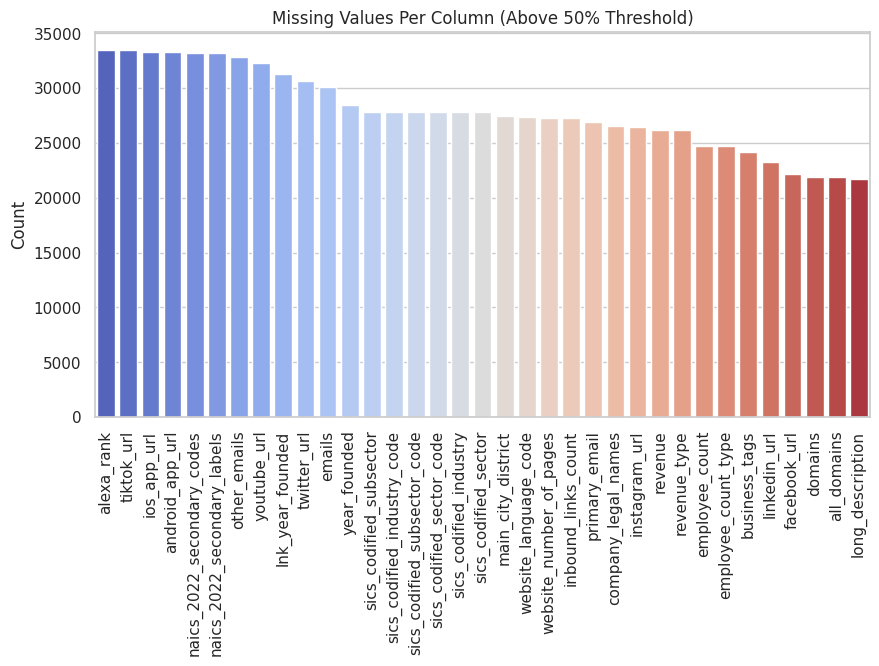

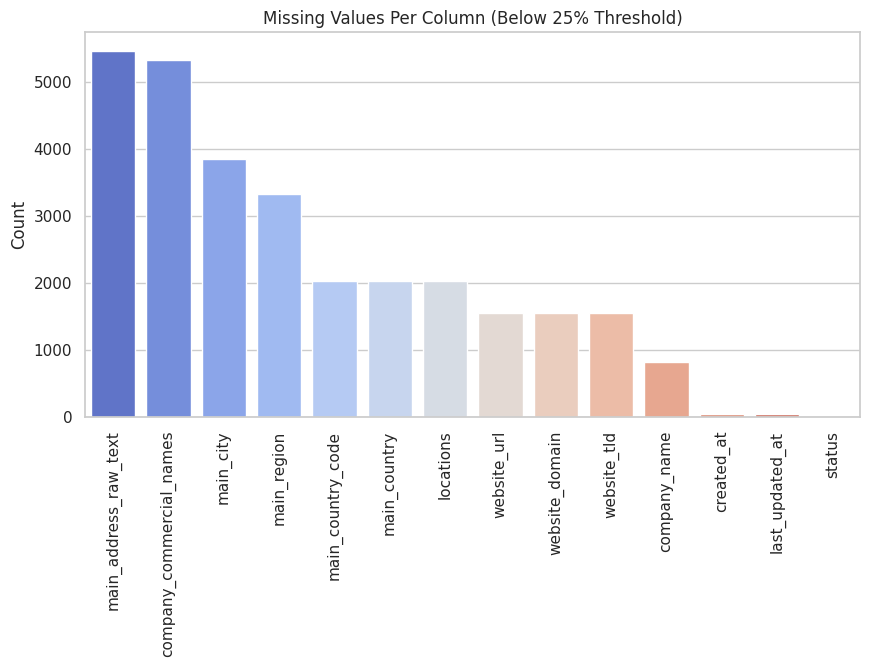

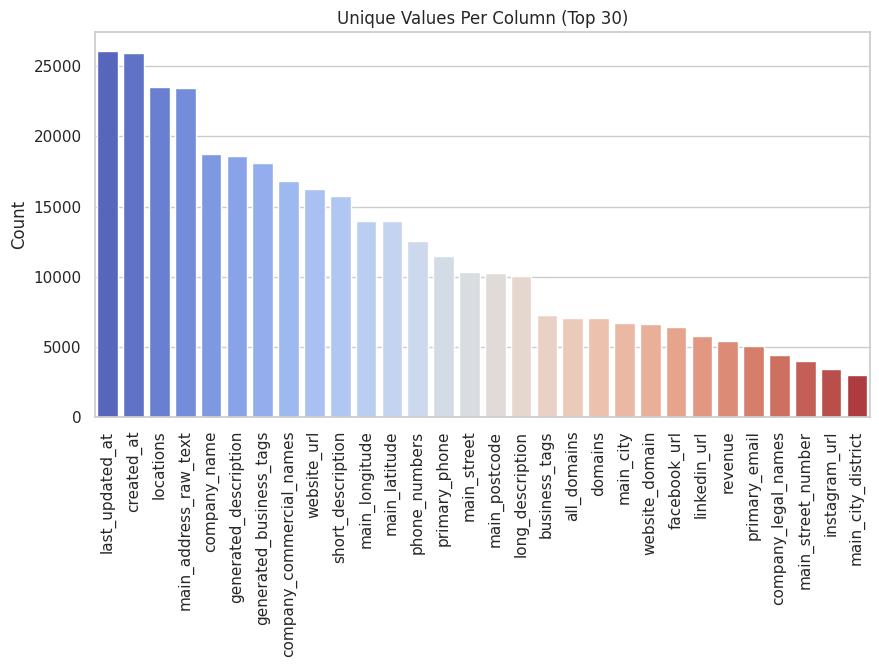

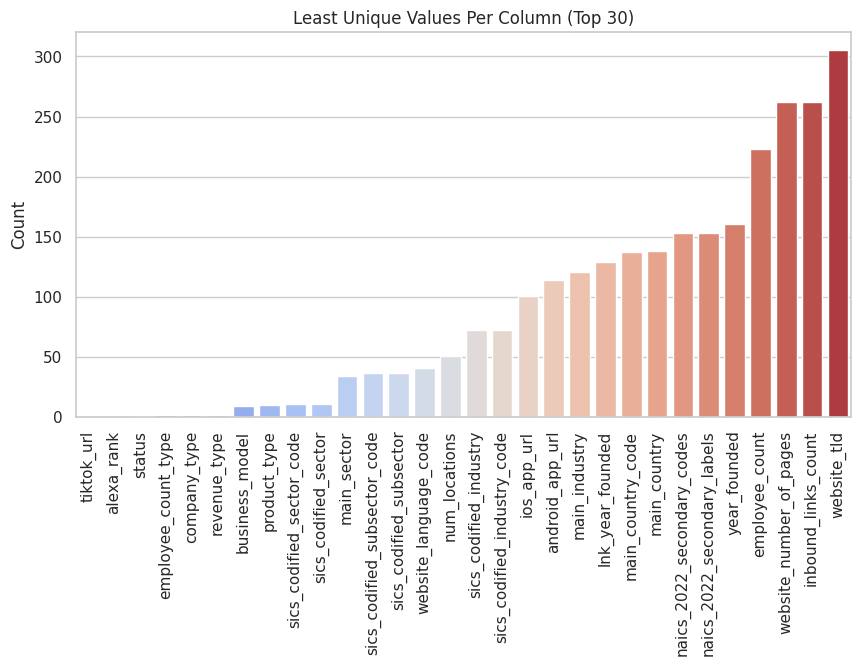


EDA Completed!
Advanced EDA Completed!


In [8]:
sns.set(style="whitegrid")


missing_values = data.isnull().sum()
missing_above_50 = missing_values[missing_values > (data.shape[0] * 0.5)].sort_values(ascending=False)
missing_below_25 = missing_values[missing_values <= (data.shape[0] * 0.25)].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_above_50.index, y=missing_above_50.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Missing Values Per Column (Above 50% Threshold)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_below_25.index, y=missing_below_25.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Missing Values Per Column (Below 25% Threshold)")
plt.ylabel("Count")
plt.show()

unique_values = data.nunique().sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique_values.index, y=unique_values.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Unique Values Per Column (Top 30)")
plt.ylabel("Count")
plt.show()

least_unique_values = data.nunique().sort_values(ascending=True).head(30)

plt.figure(figsize=(10, 5))
sns.barplot(x=least_unique_values.index, y=least_unique_values.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Least Unique Values Per Column (Top 30)")
plt.ylabel("Count")
plt.show()
print("\nEDA Completed!")

print("Advanced EDA Completed!")


## The plots above show how many of the entries available in each field in the data are missing or unique. The ones that are both mostly complete, and with a high amount of unique values could serve a good unique identifier to be used in deduplication.

## As we can see, the company name is a likely canditate for our purpose. We also may have to consider other factors, like the face that countries, cities and various buissnes metrics and categorisations are unreliable by themselveselves, we could use them as a crutch in matching regarding names.

In [9]:
data[data['company_name'].isnull()]

,company_name,company_legal_names,company_commercial_names,main_country_code,main_country,main_region,main_city_district,main_city,main_postcode,main_street,...,generated_description,generated_business_tags,status,domains,all_domains,revenue,revenue_type,employee_count,employee_count_type,inbound_links_count
19,None,None,None,DE,Germany,Hesse,None,Mörfelden-Walldorf,64546,Pragelastraße,...,medi@tects is a company based in Mörfelden-Wal...,"Design, Media, and Architecture Services | Des...",Active,None,None,None,None,None,None,None
116,None,None,None,US,United States,Illinois,None,Kankakee,60901,West Jeffery Street,...,The Kankakee Federation of Teachers Credit Uni...,Cooperative Organization | Financial Support |...,Active,kftcu.com,kftcu.com,20100000,extracted,None,None,None
165,None,None,None,None,None,None,None,None,None,None,...,None,None,Active,None,None,None,None,None,None,None
175,None,None,None,TW,Taiwan,Taichung,Longquan Village,Taichung,43770,中山路二段,...,【奶油小酥餅創始店 總店】紅櫻花食品 x Hello Kitty is a business...,Wedding Bakery | Onsite Services | Unisex Toil...,Active,None,None,None,None,None,None,None
335,None,None,None,US,United States,California,None,Apple Valley,92308,Tonikan Road,...,Roto-Rooter Plumbers and Septic Service is a c...,Septic System Maintenance | Plumbing And Repairs,Active,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33217,None,None,None,DK,Denmark,Region Of Southern Denmark,None,Varde,6800,Ambolten,...,Lauridsen Trade & Import A/S is a trading comp...,Wholesale Trade Agent Services | Trading Company,Active,None,None,None,None,None,None,None
33256,None,None,None,None,None,None,None,None,None,None,...,The 1:1 Diet by Cambridge Weight Plan is a com...,Personalized Weight Plans | Health and Wellnes...,Active,None,None,None,None,None,None,None
33286,None,None,None,GB,United Kingdom,England,None,Sutton Coldfield,B74 4PR,Park View Road,...,None,None,Active,None,None,None,None,None,None,None
33387,None,None,None,JP,Japan,Ibaraki Prefecture,None,Mito,None,None,...,None,None,Active,ibamoku.co.jp,ibamoku.co.jp,None,None,None,None,None


Ellis Cabinet & Millwork and Ellis Cabinet and Millwork are 0.92 similar and share the same location: Pembroke
Ordine degli Ingegneri della Provincia di Cremona and Ordine Degli Ingegneri Della Provincia Di Cremona are 0.94 similar and share the same location: Cremona
Ordine degli Ingegneri della Provincia di Cremona and Ordine degli Ingegneri della provincia di Cremona are 0.98 similar and share the same location: Cremona
Dawi Pharmacy and Dawi pharmacy are 0.92 similar and share the same location: Riyadh
Dimobi Childrens Disability Trust and Dimobi Children Disability Trust are 0.98 similar and share the same location: Manchester
Best Buddies Petcare and Best Buddies Petcare536 are 0.93 similar and share the same location: Leicester
Head to Toe First Aid Training and Head To Toe First Aid Training are 0.97 similar and share the same location: Powell River
Simpsons International Removals and Simpsons International Removals Ltd. are 0.93 similar and share the same location: Dartford
FC

<Figure size 800x500 with 0 Axes>

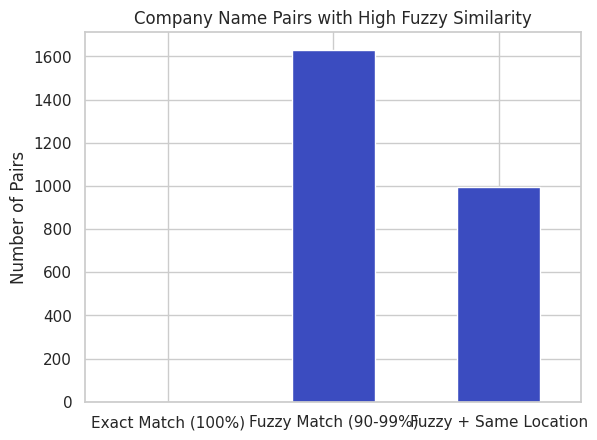

In [10]:
data = data.dropna(subset=["company_name", "main_city"]) 
company_names = data["company_name"].unique()
pairs = list(itertools.combinations(company_names, 2))
similarity_counts = {
    "Exact Match (100%)": 0,
    "Fuzzy Match (90-99%)": 0,
    "Fuzzy + Same Location": 0
}
company_location_map = data.set_index("company_name")["main_city"].to_dict()
for name1, name2 in pairs:
    similarity = fuzz.ratio(name1, name2) / 100
    loc1 = company_location_map.get(name1, "Unknown")
    loc2 = company_location_map.get(name2, "Unknown")

    if similarity == 1.0:
        similarity_counts["Exact Match (100%)"] += 1
    elif similarity >= 0.90:
        similarity_counts["Fuzzy Match (90-99%)"] += 1
        if loc1 == loc2:
            similarity_counts["Fuzzy + Same Location"] += 1
            print(f"{name1} and {name2} are {similarity:.2f} similar and share the same location: {loc1}")

similarity_df = pd.DataFrame.from_dict(similarity_counts, orient="index", columns=["Count"])

plt.figure(figsize=(8, 5))
similarity_df.plot(kind="bar", legend=False, colormap="coolwarm")
plt.ylabel("Number of Pairs")
plt.title("Company Name Pairs with High Fuzzy Similarity")
plt.xticks(rotation=0)
plt.show()


## We have to keep in mind that since our entries come from various sources ,so typos, punctuation, and other minute differences can make the same company name to appear in different ways, so a hard matching would not come with success.So, we chose to match together names that show a high degree of similarity. Even in this case, we run the risk of similar names to belong to differing companies, or entire different branches of the same one. We will also use the city as a further maching item, and while this method carries its risks, for the current computational limiatation, should deliver a good enough result

##  The following logic will be used to form our results:we begin by normalizing company names and use MinHash with LSH to quickly identify similar ones. Companies with ≥90% similarity are grouped and merged, aiming to preserve as much information coming from all sources as possible(although this aproach carries inherent risks, as in mistakes in the matching may cause false info to be atributed and propagate the mistake). For unnamed records, we assign the name of the company with the most shared structured attributes, ensuring accurate deduplication with minimal errors.

In [11]:
def normalize_text(text):
    if pd.isna(text):
        return ""
    text = text.lower().strip()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text

def create_minhash(text, num_perm=128):
    minhash = MinHash(num_perm=num_perm)
    for word in text.split():
        minhash.update(word.encode("utf8"))
    return minhash

def fast_fuzzy_merging(data, similarity_threshold=90, strong_match_threshold=95):
    data = data.copy()
    data.loc[:, "normalized_name"] = data["company_name"].apply(normalize_text)

    lsh = MinHashLSH(threshold=0.85, num_perm=128)
    minhash_dict = {}

    for name in data["normalized_name"].dropna().unique():
        mh = create_minhash(name)
        minhash_dict[name] = mh
        lsh.insert(name, mh)

    name_groups = {}

    for name in data["normalized_name"].dropna().unique():
        similar_names = lsh.query(minhash_dict[name])

        main_name = data[data["normalized_name"] == name]["company_name"].iloc[0]
        for match in similar_names:
            if match != name:
                score = fuzz.token_sort_ratio(name, match)
                if score >= strong_match_threshold:
                    name_groups[match] = main_name
                elif score >= similarity_threshold and name_groups.get(match) is None:
                    name_groups[match] = main_name

    data.loc[:, "grouped_company_name"] = data["normalized_name"].map(name_groups).fillna(data["company_name"])

    condensed_rows = []
    for info in data["grouped_company_name"].dropna().unique():
        subset = data[data["grouped_company_name"] == info]
        condensed_row = subset.iloc[0].copy()
        for i in range(1, len(subset)):
            condensed_row = condensed_row.combine_first(subset.iloc[i])
        condensed_rows.append(condensed_row)

    merged_data = pd.DataFrame(condensed_rows).drop(columns=["normalized_name", "grouped_company_name"])

    # Handle NULL company names by finding the best-matching company based on shared attributes
    null_names = merged_data[merged_data["company_name"].isna()]
    named_data = merged_data.dropna(subset=["company_name"])

    for idx, row in null_names.iterrows():
        best_match = None
        max_matches = 0

        for _, candidate in named_data.iterrows():
            matches = sum(
                (pd.notna(row[field]) and pd.notna(candidate[field]) and row[field] == candidate[field])
                for field in ["main_city", "main_street", "main_postcode", "primary_phone", "primary_email"]
            )

            if matches > max_matches:
                max_matches = matches
                best_match = candidate["company_name"]

        merged_data.at[idx, "company_name"] = best_match

    return merged_data

data = fast_fuzzy_merging(data)

print("Done")

Done


In [12]:
data

,company_name,company_legal_names,company_commercial_names,main_country_code,main_country,main_region,main_city_district,main_city,main_postcode,main_street,...,generated_description,generated_business_tags,status,domains,all_domains,revenue,revenue_type,employee_count,employee_count_type,inbound_links_count
0,Owens Liquors,None,Owens Liquors,US,United States,South Carolina,None,Pawleys Island,29585,Ocean Highway,...,Owens Liquors is a retail establishment locate...,Retail Trade | Liquor Stores | Wine & Liquor,Active,None,None,None,None,None,None,None
1,Club Tarneit,None,Club Tarneit,AU,Australia,Victoria,Tarneit,City Of Wyndham,3029,Leakes Road,...,The Club Tarneit is an event venue located in ...,Credit Card Payment | Bathroom Facilities | Wh...,Active,clubtarneit.com.au,clubtarneit.com.au,1481783,modelled,9,extracted,16
2,AAA Auto Otrokovice Zlín,None,AAA Auto Otrokovice Zlín,CZ,Czechia,Zlín,Kvítkovice U Otrokovic,Otrokovice,765 02,Zlínská,...,AAA Auto Otrokovice (Zlín) is a car dealership...,In-store Shopping | Investment Management Serv...,Active,None,None,None,None,None,None,None
3,Gisinger GmbH,Gisinger GmbH,None,DE,Germany,Baden-Württemberg,None,Ühlingen-Birkendorf,79777,Berauer Straße,...,Gisinger GmbH is a taxi service company based ...,Wheelchair Parking | Transportation Services,Active,gisinger-gmbh.de,gisinger-gmbh.de,None,None,9,extracted,None
4,Kasana Life,None,Kasana Life,US,United States,Connecticut,Litchfield (borough),Litchfield,06759,West Street,...,Kasana Life is a wellness company that offers ...,Sacred Wellness | Advanced Transformational En...,Active,kasanalife.com,kasanalife.com,7900000,extracted,1,extracted,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33437,Westbrook,None,Westbrook,US,United States,Maine,None,Westbrook,04092,Hemphill Drive,...,"Westbrook is a town located in Westbrook, Main...",Custom Programming Services | Health and Beaut...,Active,None,None,None,None,None,None,None
33442,SPORT4U parduotuvė - UAB Vitaga ir ko,None,SPORT4U parduotuvė - UAB Vitaga ir ko,LT,Lithuania,Kaunas County,None,Kaunas,LT-51189,Pramonės Pr.,...,"SPORT4U parduotuvė - UAB ""Vitaga"" ir ko is a s...",In-store Pickup | In-store Shopping | Wheelcha...,Active,None,None,None,None,None,None,None
33443,City Sightseeing Norwich,None,City Sightseeing Norwich,GB,United Kingdom,England,None,Cromer,None,None,...,The company offers open-top bus tours in Norwi...,Open Bus Transportation | Transportation Services,Active,city-sightseeing.com,city-sightseeing.com,None,None,None,None,None
33444,Trimbakeshwar Jyotirling Temple,None,Trimbakeshwar Jyotirling Temple,IN,India,Maharashtra,None,Nashik,422003,College Road,...,The Trimbakeshwar Jyotirling Temple is a Hindu...,Cleanliness Services | H Accommodation Service...,Active,None,None,None,None,None,None,None


In [13]:
data.to_csv('data_cleaned.csv', index=False)